In [1]:
from skimage import filters
import pickle
import os
from metadata import Metadata
import time
from skimage.morphology import selem
from skimage.morphology import dilation
from scipy.ndimage import gaussian_filter
import numpy as np
import pandas as pd
import itertools as it
from skimage.feature import peak_local_max
from skimage.measure import label,regionprops
from skimage.morphology import watershed


#This function loads images, substract background and append a list of selected images to df
def pfunc_zstk_filt(Input):
    pname = Input['pname']
    threshold = Input['threshold']
    md_local = Input['md_local']
    acq = Input['acq']
    chan = Input['chan']
    blur = Input['blur']
    rel_thresh = Input['rel_thresh']
    npixels_thresh = Input['npixels_thresh']
    pos_path = Input['pos_path']
    if os.path.exists(os.path.join(pos_path,'df.pkl')):
        return
    print(pname, '\n')
    disk = selem.disk(2)
    stk = md_local.stkread(Position=pname, Channel=chan, acq=acq)#loading images
    
    #check if the type of stk is dictionary, print the position, channel, and aquisition
    if type(stk)==dict:
        print('stk empty')
        print('Pos: ',pname)
        print('Channel: ',chan)
        print('Acq: ',acq)
        return
    
   # background subtraction
    fstk = diffGauss(stk, blur)
    
    # returns the coordinates of local peaks (maxima) in an image
    peaks_coords = peak_local_max(fstk, threshold_abs=threshold,
                                  min_distance=3)
    peaks = peak_local_max(fstk, threshold_abs=threshold,
                           min_distance=3, indices=False)
    dfs = []
 
    for z in set(peaks_coords[:, 2]):
        img = fstk[:,:,z]
        labels = label(peaks[:, :, z])
        #watershed is used for image segmentation
        spot_labels = watershed(gaussian_filter(img, 1.2)*-1, labels, mask=dilation(peaks[:,:, z], selem=disk))
        spots = regionprops(spot_labels, img)#Measure properties of labeled image regions
        npixels = np.array([p.area for p in spots])#creates an array
        spot_means = np.array([p.mean_intensity for p in spots])
        spot_max = [p.max_intensity for p in spots]
        centroids = np.array([p.weighted_centroid for p in spots])
    #     rna = np.where((spot_means>threshold)&(npixels>=npixels_thresh))[0]
        rna = np.arange(len(spots))
        rna_coords = centroids[rna]
        spot_values = []
        for p in spots:
            vals = [img[y, x] for y, x in p.coords]
            spot_values.append(vals)#append coordinates to spot_value

        df = pd.DataFrame(np.stack([spot_means[rna], rna_coords[:,0],
                                    rna_coords[:, 1],
                                    tuple(it.repeat(z, len(spot_means[rna])))], axis=1),
                          columns = ['val', 'y', 'x', 'z'])#Join a sequence of arrays along new axises.
        df['pixel_values'] = spot_values
        dfs.append(df)
    df = pd.concat(dfs, ignore_index=True)
    npixels = []
    ssum = []
    stdpixels = []
    for pixel_values in df.pixel_values:
        pixel_array = np.array(pixel_values)
        npixels.append(len(pixel_array[pixel_array>npixels_thresh]))
        ssum.append(np.sum(pixel_values))
        stdpixels.append(np.std(pixel_values))
    df['npixels'] = npixels
    df['ssum'] = ssum
    df['stdpixels'] = stdpixels
    pickle.dump(pname,open(os.path.join(pos_path,'pname.pkl'),'wb'))
    pickle.dump(fstk.max(axis=2),open(os.path.join(pos_path,'fstk_max.pkl'),'wb'))
    pickle.dump(df,open(os.path.join(pos_path,'df.pkl'),'wb'))
    pickle.dump(spot_labels,open(os.path.join(pos_path,'spot_labels.pkl'),'wb'))

    return


# This function sets blur magnitude and substract the background
def diffGauss(stk, blur = (0.5,0.5,0.)):
    stk = stk.astype('float64')
    stk = stk.copy()
    lp = gaussian_filter(stk, blur)
    stk = stk-lp
    stk = gaussian_filter(stk, (0.25,0.25,0.25))
    np.place(stk, stk<0, 0)
    return stk.astype('int16')



In [2]:
Inputs = []
md_path = '/hybedata/Images/Zach/FISH_Signal_Amp/IDT_PER_2019Sep10/PER_100ms_2/'
save_path = '/hybedata/Images/Zach/FISH_Signal_Amp/per_quant'
if not os.path.exists(save_path):
    os.mkdir(save_path)
sigmas = ['low','med','high']
colors = ['FarRed','Orange']
threshold = 200
md = Metadata(md_path)
acq = md.image_table.acq.unique()[0]
rel_thresh = 0.2
npixels_thresh = 6

for color in colors:
    color_path = os.path.join(save_path,color)
    if not os.path.exists(color_path):
        os.mkdir(color_path)
    for sigma in sigmas:
        if sigma == 'low':
            blur = (2.2,2.2,2.2)
        elif sigma == 'med':
            blur = (5,5,5)
        elif sigma=='high':
            blur = (10,10,10)
        else:
            print('sigma error: ',sigma)
        sigma_path = os.path.join(color_path,sigma)
        if not os.path.exists(sigma_path):
            os.mkdir(sigma_path)
        for pos in md.image_table.Position.unique():
            pos_path = os.path.join(sigma_path,pos)
            if not os.path.exists(pos_path):
                os.mkdir(pos_path)
            Input = {}
            Input['pname'] = pos
            Input['threshold'] = threshold
            Input['md_local'] = md
            Input['acq'] = acq
            Input['chan'] = color
            Input['blur'] = blur
            Input['rel_thresh'] = rel_thresh
            Input['npixels_thresh'] = npixels_thresh
            Input['pos_path'] = pos_path
            Inputs.append(Input)


In [3]:
import multiprocessing
import sys
ncpu = 50
with multiprocessing.Pool(ncpu) as ppool:
    sys.stdout.flush()
    ppool.map(pfunc_zstk_filt, Inputs)
    ppool.close()
    sys.stdout.flush()

1-Pos_000_000 

1-Pos_000_001 

1-Pos_000_002 

opening img_1-Pos_000_000_000000002_000000000_FarRed_000_002.tif1-Pos_000_003 

opening img_1-Pos_000_001_000000001_000000000_FarRed_000_001.tif1-Pos_001_003 

opening img_1-Pos_000_002_000000001_000000000_FarRed_000_001.tif1-Pos_000_004 

opening img_1-Pos_000_002_000000002_000000000_FarRed_000_002.tif1-Pos_001_004 

opening img_1-Pos_000_000_000000003_000000000_FarRed_000_003.tif1-Pos_002_004 

opening img_1-Pos_000_003_000000002_000000000_FarRed_000_002.tif1-Pos_003_004 

1-Pos_004_004 

opening img_1-Pos_000_004_000000002_000000000_FarRed_000_002.tif1-Pos_004_003 

opening img_1-Pos_000_000_000000004_000000000_FarRed_000_004.tif1-Pos_004_002 

1-Pos_003_002 

1-Pos_003_003 

1-Pos_002_003 

opening img_1-Pos_001_003_000000001_000000000_FarRed_000_001.tif
1-Pos_002_002 
opening img_1-Pos_001_003_000000002_000000000_FarRed_000_002.tif1-Pos_001_002 

1-Pos_001_001 

opening img_1-Pos_001_004_000000001_000000000_FarRed_000_001.tif1-Pos_00

opening img_1-Pos_003_004_000000026_000000000_Orange_000_026.tif1-Pos_004_004 

opening img_1-Pos_004_004_000000026_000000000_Orange_000_026.tif1-Pos_004_003 

opening img_1-Pos_004_003_000000026_000000000_Orange_000_026.tif1-Pos_004_002 

opening img_1-Pos_004_002_000000026_000000000_Orange_000_026.tif1-Pos_003_002 

opening img_1-Pos_003_002_000000020_000000000_Orange_000_020.tif1-Pos_003_003 

opening img_1-Pos_003_003_000000026_000000000_Orange_000_026.tif1-Pos_002_003 

opening img_1-Pos_002_003_000000026_000000000_Orange_000_026.tif1-Pos_002_002 

opening img_1-Pos_002_002_000000026_000000000_Orange_000_026.tif1-Pos_001_002 

opening img_1-Pos_001_002_000000026_000000000_Orange_000_026.tif1-Pos_001_001 

opening img_1-Pos_001_001_000000023_000000000_Orange_000_023.tif1-Pos_002_001 

opening img_1-Pos_002_001_000000026_000000000_Orange_000_026.tif1-Pos_003_001 

opening img_1-Pos_003_001_000000026_000000000_Orange_000_026.tif1-Pos_004_001 

opening img_1-Pos_004_001_000000026_0000

In [4]:
save_path = '/hybedata/Images/Zach/FISH_Signal_Amp/per_quant'
Inputs = []
for color in os.listdir(save_path):
    color_path = os.path.join(save_path,color)
    for sigma in os.listdir(color_path):
        sigma_path = os.path.join(color_path,sigma)
        Input = {}
        Input['base_path'] = sigma_path
        Input['pos_paths'] = []
        for pos in os.listdir(sigma_path):
            pos_path = os.path.join(sigma_path,pos)
            Input['pos_paths'].append(pos_path)
        Inputs.append(Input)

In [7]:
def pos_df_concat(Input):
    base_path = Input['base_path']
    print(base_path)
    pos_paths = Input['pos_paths']
    out_path = os.path.join(base_path,'results')
    if not os.path.exists(out_path):
            os.mkdir(out_path)
    if os.path.exists(os.path.join(out_path,'df.pkl')):
            if os.path.exists(os.path.join(out_path,'good_df.pkl')):
                if os.path.exists(os.path.join(out_path,'bad_df.pkl')):
                    return
    df_list = []
    for pos_path in pos_paths:
        pos_df = pickle.load(open(os.path.join(pos_path,'df.pkl'),'rb'))
        df_list.append(pos_df)
    df = pd.concat(df_list, ignore_index=True)
    intensity_thresh = 10**1.8
    npixels_thresh = 0
    ssum_thresh = filters.threshold_otsu(np.array(df.ssum))
    std_thresh = filters.threshold_otsu(np.array(df.stdpixels))
    good_df = df[(df.val>intensity_thresh)]
    bad_df = df[(df.val<=intensity_thresh)]
    pickle.dump(df,open(os.path.join(out_path,'df.pkl'),'wb'))
    pickle.dump(good_df,open(os.path.join(out_path,'good_df.pkl'),'wb'))
    pickle.dump(bad_df,open(os.path.join(out_path,'bad_df.pkl'),'wb'))
    return

In [8]:
import multiprocessing
import sys
ncpu = 6
with multiprocessing.Pool(ncpu) as ppool:
    sys.stdout.flush()
    ppool.map(pos_df_concat, Inputs)
    ppool.close()
    sys.stdout.flush()

/hybedata/Images/Zach/FISH_Signal_Amp/per_quant/Orange/high
/hybedata/Images/Zach/FISH_Signal_Amp/per_quant/Orange/med
/hybedata/Images/Zach/FISH_Signal_Amp/per_quant/FarRed/high
/hybedata/Images/Zach/FISH_Signal_Amp/per_quant/FarRed/low
/hybedata/Images/Zach/FISH_Signal_Amp/per_quant/FarRed/med
/hybedata/Images/Zach/FISH_Signal_Amp/per_quant/Orange/low


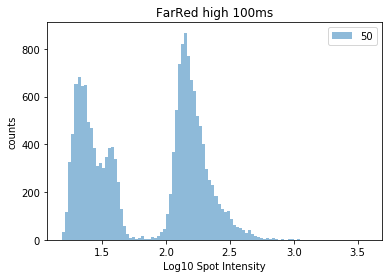

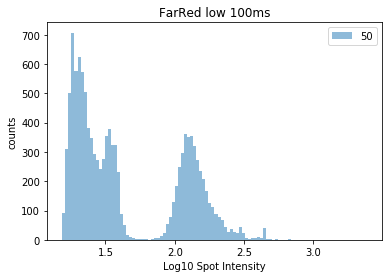

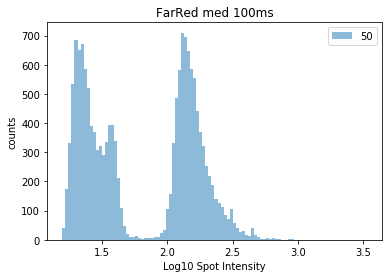

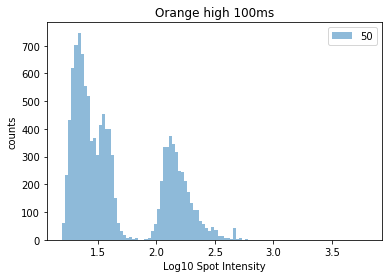

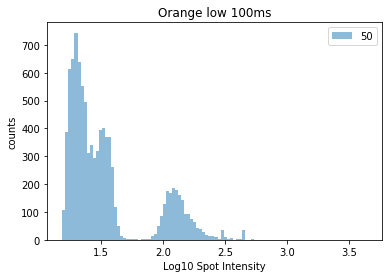

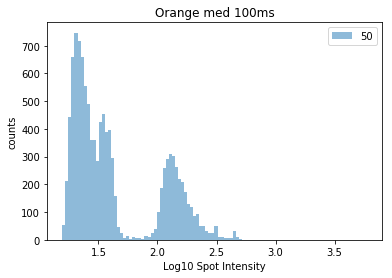

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
save_path = '/hybedata/Images/Zach/FISH_Signal_Amp/per_quant/'
for color in os.listdir(save_path):
    color_path = os.path.join(save_path,color)
    for sigma in os.listdir(color_path):
        sigma_path = os.path.join(color_path,sigma)
        for result in os.listdir(sigma_path):
            if not 'results' in result:
                continue
            result_path = os.path.join(sigma_path,result)
            df = pickle.load(open(os.path.join(result_path,'df.pkl'),'rb'))
            plt.hist(np.log10(df.val),bins=100,label=conc,alpha=0.5)
        plt.title(str(color+' '+sigma+' 100ms'))
        plt.xlabel('Log10 Spot Intensity')
        plt.ylabel('counts')
        plt.legend()
        plt.show()

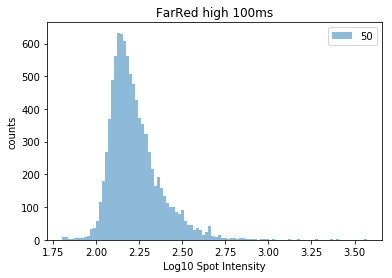

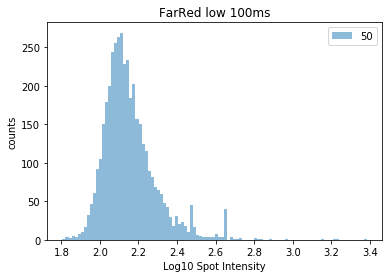

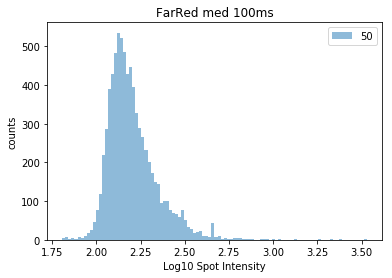

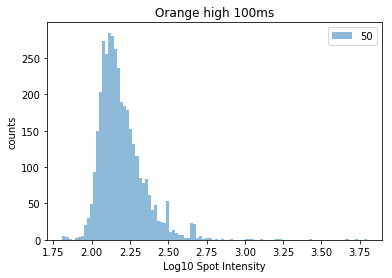

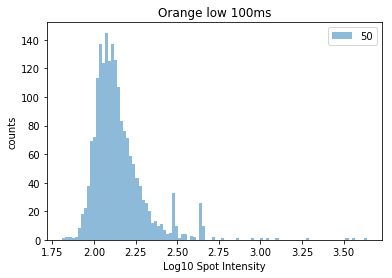

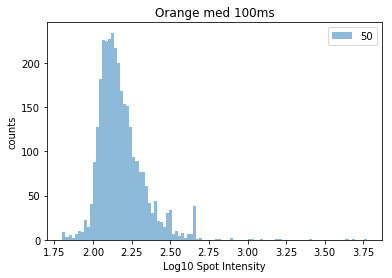

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
save_path = '/hybedata/Images/Zach/FISH_Signal_Amp/per_quant/'
for color in os.listdir(save_path):
    color_path = os.path.join(save_path,color)
    for sigma in os.listdir(color_path):
        sigma_path = os.path.join(color_path,sigma)
        for result in os.listdir(sigma_path):
            if not 'results' in result:
                continue
            result_path = os.path.join(sigma_path,result)
            df = pickle.load(open(os.path.join(result_path,'good_df.pkl'),'rb'))
            plt.hist(np.log10(df.val),bins=100,label=conc,alpha=0.5)
        plt.title(str(color+' '+sigma+' 100ms'))
        plt.xlabel('Log10 Spot Intensity')
        plt.ylabel('counts')
        plt.legend()
        plt.show()

In [63]:
save_path = '/hybedata/Images/Zach/FISH_Signal_Amp/per_quant/'
color = 'Orange'
sigma = 'high'
result = 'results'
color_path = os.path.join(save_path,color)
sigma_path = os.path.join(color_path,sigma)
result_path = os.path.join(sigma_path,result)
df = pickle.load(open(os.path.join(result_path,'df.pkl'),'rb'))

In [62]:
print(np.median(df[df.val>10**2].val)/np.median(df[df.val<10**2].val))

6.2171253822629975


In [64]:
print(np.median(df[df.val>10**2].val)/np.median(df[df.val<10**2].val))

5.826219512195122


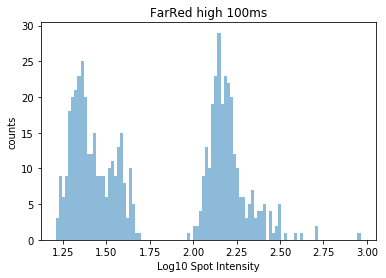

In [49]:
plt.hist(np.log10(df.val),bins=100,alpha=0.5)
plt.title(str(color+' '+sigma+' 100ms'))
plt.xlabel('Log10 Spot Intensity')
plt.ylabel('counts')
plt.show()

In [50]:
good_df = df[df.val>10**2]
print(len(good_df))

278


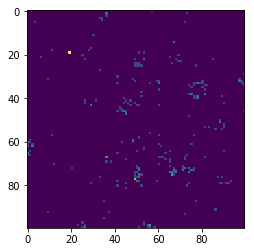

In [51]:
%matplotlib inline
xy = np.histogram2d(good_df.y,good_df.x,bins=100)
plt.imshow(xy[0])

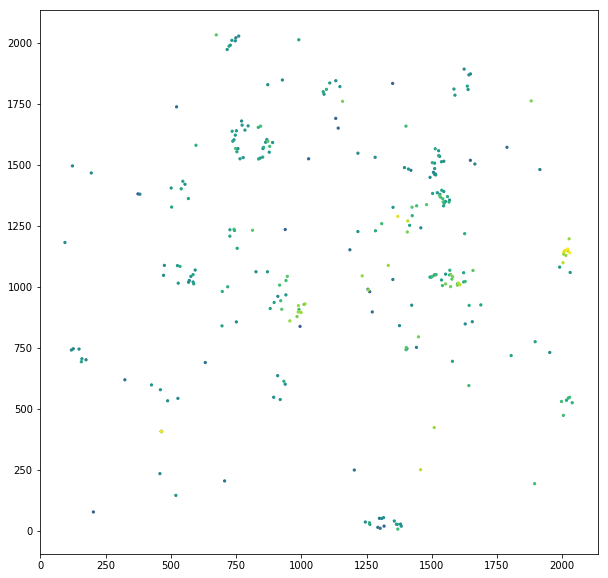

In [54]:
%matplotlib inline
plt.figure(figsize=(10,10))
plt.scatter(good_df.y,good_df.x,c=good_df.z,s=5)
plt.show()

In [23]:
save_path = '/hybedata/Images/Zach/FISH_Signal_Amp/per_conc_results'
conc = '50nM_PER'
color = 'Orange'
sigma = 'high'
color_path = os.path.join(save_path,color)
sigma_path = os.path.join(color_path,sigma)
conc_path = os.path.join(sigma_path,conc)
df = pickle.load(open(os.path.join(conc_path,'good_df.pkl'),'rb'))
len(df)/25

720.8

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
results = {}
save_path = '/hybedata/Images/Zach/FISH_Signal_Amp/per_conc_results'
for color in os.listdir(save_path):
    results[color] = {}
    color_path = os.path.join(save_path,color)
    for sigma in os.listdir(color_path):
        results[color][sigma] = {}
        sigma_path = os.path.join(color_path,sigma)
        for conc in os.listdir(sigma_path):
            if not 'PER' in conc:
                continue
            results[color][sigma][conc] = {}
            print(conc,' ',sigma,' ', color, ' 100ms')
            conc_path = os.path.join(sigma_path,conc)
            good_df = pickle.load(open(os.path.join(conc_path,'good_df.pkl'),'rb'))
            bad_df = pickle.load(open(os.path.join(conc_path,'bad_df.pkl'),'rb'))
            results[color][sigma][conc]['s/n'] = np.mean(good_df.val)/np.mean(bad_df.val)
            results[color][sigma][conc]['number'] = len(good_df)
            results[color][sigma][conc]['signal'] = np.mean(good_df.val)
            results[color][sigma][conc]['background'] = np.mean(bad_df.val)



25nM_PER   high   FarRed  100ms
50nM_PER   high   FarRed  100ms
0nM_PER   high   FarRed  100ms
10nM_PER   high   FarRed  100ms
5nM_PER   high   FarRed  100ms
25nM_PER   low   FarRed  100ms
50nM_PER   low   FarRed  100ms
0nM_PER   low   FarRed  100ms
10nM_PER   low   FarRed  100ms
5nM_PER   low   FarRed  100ms
25nM_PER   med   FarRed  100ms
50nM_PER   med   FarRed  100ms
0nM_PER   med   FarRed  100ms
10nM_PER   med   FarRed  100ms
5nM_PER   med   FarRed  100ms
25nM_PER   high   Orange  100ms
50nM_PER   high   Orange  100ms
0nM_PER   high   Orange  100ms
10nM_PER   high   Orange  100ms
5nM_PER   high   Orange  100ms
25nM_PER   low   Orange  100ms
50nM_PER   low   Orange  100ms
0nM_PER   low   Orange  100ms
10nM_PER   low   Orange  100ms
5nM_PER   low   Orange  100ms
25nM_PER   med   Orange  100ms
50nM_PER   med   Orange  100ms
0nM_PER   med   Orange  100ms
10nM_PER   med   Orange  100ms
5nM_PER   med   Orange  100ms


In [16]:
sigma_result.keys()


dict_keys(['25nM_PER', '50nM_PER', '0nM_PER', '10nM_PER', '5nM_PER'])

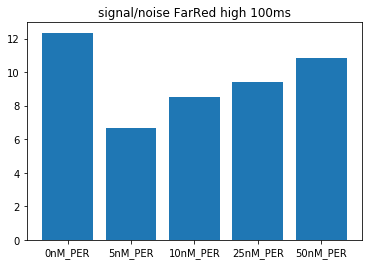

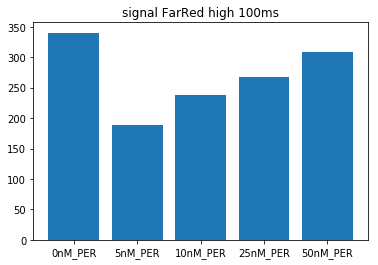

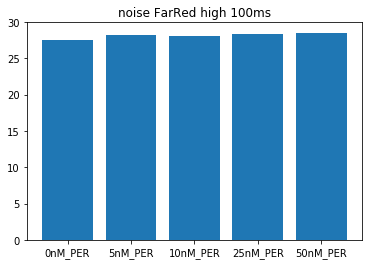

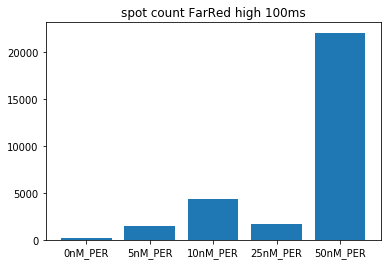

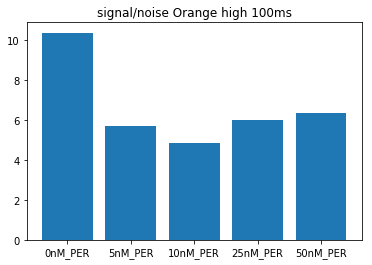

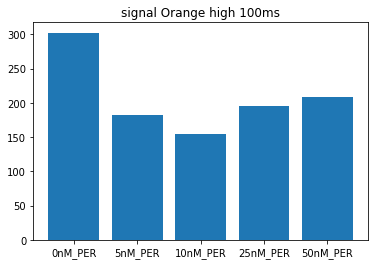

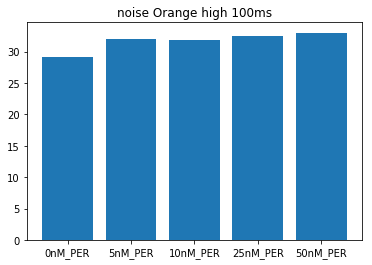

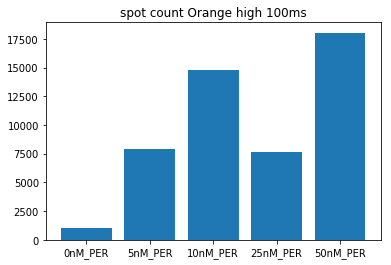

In [22]:
conc_list = ['0nM_PER','5nM_PER','10nM_PER','25nM_PER','50nM_PER',]
for color,color_result in results.items():
    for sigma,sigma_result in color_result.items():
        if not 'high' in sigma:
            continue
        SN = []
        S = []
        N = []
        num = []
        CONC = []
        for conc in conc_list:
            conc_result = sigma_result[conc]
            SN.append(conc_result['s/n'])
            S.append(conc_result['signal'])
            N.append(conc_result['background'])
            num.append(conc_result['number'])
            CONC.append(conc)
#         plt.scatter(CONC,SN)
#         plt.title('signal/noise '+color+' '+sigma+' 100ms')
#         plt.show()
#         plt.scatter(CONC,S)
#         plt.title('signal '+color+' '+sigma+' 100ms')
#         plt.show()
#         plt.scatter(CONC,N)
#         plt.title('noise '+color+' '+sigma+' 100ms')
#         plt.show()
#         plt.scatter(CONC,num)
#         plt.title('spot count '+color+' '+sigma+' 100ms')
#         plt.show()
#         plt.plot(CONC,SN)
#         plt.title('signal/noise '+color+' '+sigma+' 100ms')
#         plt.show()
#         plt.plot(CONC,S)
#         plt.title('signal '+color+' '+sigma+' 100ms')
#         plt.show()
#         plt.plot(CONC,N)
#         plt.title('noise '+color+' '+sigma+' 100ms')
#         plt.show()
#         plt.plot(CONC,num)
#         plt.title('spot count '+color+' '+sigma+' 100ms')
#         plt.show()
        plt.bar(CONC,SN)
        plt.title('signal/noise '+color+' '+sigma+' 100ms')
        plt.show()
        plt.bar(CONC,S)
        plt.title('signal '+color+' '+sigma+' 100ms')
        plt.show()
        plt.bar(CONC,N)
        plt.title('noise '+color+' '+sigma+' 100ms')
        plt.show()
        plt.bar(CONC,num)
        plt.title('spot count '+color+' '+sigma+' 100ms')
        plt.show()

In [112]:
from random import choice
from Bio import SeqUtils
Nucelotides = 'ACGT'
candidates = []
while len(candidates)<500:
    candidate =''.join(choice(Nucelotides) for i in range(4))
    Gc_cont = SeqUtils.GC(candidate)
    if Gc_cont>75 or Gc_cont<25:
        continue
    if not candidate in candidates:
        candidates.append(candidate)

KeyboardInterrupt: 

In [99]:
candidate

'CATGG'

In [100]:
Gc_cont

60.0

In [97]:
4**5

1024

In [113]:
len(np.unique(candidates))

224

In [85]:
4**4

256

In [107]:
candidates

['TGTC',
 'TCAT',
 'CCCA',
 'GGTA',
 'GTCC',
 'CATA',
 'ACCC',
 'AGGA',
 'GTTT',
 'GGAA',
 'CTGA',
 'CACG',
 'AGGC',
 'TCTG',
 'AGCG',
 'CGTC',
 'TTGG',
 'GACC',
 'TGGC',
 'CCAC',
 'GTGA',
 'AGTT',
 'ACTA',
 'CTTG',
 'AAAC',
 'CTAA',
 'ATTC',
 'CGAT',
 'CTAG',
 'TCTT',
 'CCAG',
 'TCGG',
 'TGAG',
 'TGCA',
 'GTAC',
 'GTTG',
 'CTCG',
 'GAGG',
 'CCTC',
 'TCTA',
 'ACGC',
 'TTTC',
 'GAGA',
 'GGCA',
 'AGAC',
 'GTGT',
 'TCCC',
 'TGAC',
 'ACGG',
 'GCAG',
 'TGCG',
 'TTGA',
 'GTGC',
 'CTTT',
 'CTGG',
 'TCAG',
 'TAAC',
 'GTAA',
 'ATAG',
 'TTAG',
 'ACGT',
 'GTAG',
 'GATT',
 'CAGA',
 'TAAG',
 'ACTG',
 'TGTA',
 'CTCA',
 'AACC',
 'AGGG',
 'ACCT',
 'AGAA',
 'TTAC',
 'TACA',
 'TTCT',
 'ACCG',
 'TCGA',
 'ATCG',
 'CCCT',
 'AGAG',
 'TACT',
 'CGGT',
 'TGTG',
 'TTCG',
 'ACGA',
 'ATCT',
 'ATCA',
 'GCAA',
 'TATC',
 'ACAT',
 'GACT',
 'CTCT',
 'GCAT',
 'TCGC',
 'AATG',
 'ACAG']

In [114]:
pd.DataFrame(candidates).to_csv('/home/zach/Desktop/Maeve_seq.csv')